In [3]:
# Imports
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt

# import seaborn by "pip install seaborn" 
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# import machine learning libraries
from sklearn import cross_validation
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Get titanic & test csv files as a DataFrame
titanic_df = pd.read_csv("train.csv", dtype={"Age": np.float64}, )
test_df    = pd.read_csv("test.csv", dtype={"Age": np.float64}, )

In [4]:
# preview the data
print titanic_df.head()

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [5]:
# print details
titanic_df.info()
print("----------------------------")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare

In [6]:
# drop the ticket columns in each, it is just a ticket number so is unlikely to be useful in analysis and prediction
titanic_df = titanic_df.drop(['PassengerId','Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

In [7]:
# TITLE
# Create new title column and get title by splitting the passenger name column
titanic_df['Title'] = titanic_df['Name'].apply(lambda x: x.split(',')[1].strip().split('.')[0])
test_df['Title'] = test_df['Name'].apply(lambda x: x.split(',')[1].strip().split('.')[0])

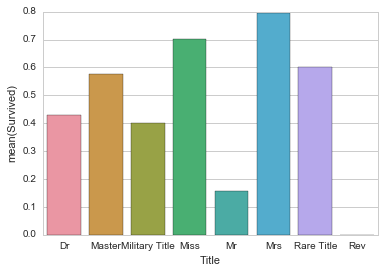

In [8]:
# In titanic_df change Mlle and Ms to Miss, Mme to Mrs. Changed Col, Major and Capt to Military Title and all others to Rare Title
titanic_df['Title'] = np.where(titanic_df['Title'].isin(['Mlle', 'Ms']), 'Miss', titanic_df['Title'])
titanic_df['Title'] = np.where(titanic_df['Title'].isin(['Mme']), 'Mrs', titanic_df['Title'])
titanic_df['Title'] = np.where(titanic_df['Title'].isin(['Major', 'Col', 'Capt']), 'Military Title', titanic_df['Title'])
titanic_df['Title'] = np.where(titanic_df['Title'].isin(['Jonkheer', 'Lady', 'Don', 'Dona', 'the Countess', 'Sir']), 'Rare Title', titanic_df['Title'])

# Plot Title vs Survived
title_perc = titanic_df[['Title', 'Survived']].groupby(['Title'], as_index = False).mean()
sns.barplot(x = 'Title', y = 'Survived', data = title_perc)


In [9]:
# Make the same changes in test_df
test_df['Title'] = np.where(test_df['Title'].isin(['Mlle', 'Ms']), 'Miss', test_df['Title'])
test_df['Title'] = np.where(test_df['Title'].isin(['Mme']), 'Mrs', test_df['Title'])
test_df['Title'] = np.where(test_df['Title'].isin(['Major', 'Col', 'Capt']), 'Military Title', test_df['Title'])
test_df['Title'] = np.where(test_df['Title'].isin(['Jonkheer', 'Lady', 'Don', 'Dona', 'the Countess', 'Sir']), 'Rare Title', test_df['Title'])

# Need to create dummy variables to handle categorical data for sklearn
title_dummies_titanic = pd.get_dummies(titanic_df['Title'])
title_dummies_test = pd.get_dummies(test_df['Title'])

titanic_df = titanic_df.join(title_dummies_titanic)
test_df = test_df.join(title_dummies_test)

# Drop Name variable and drop Title as the data is contained in new dummy variables
titanic_df = titanic_df.drop(['Name', 'Title'], axis=1)
test_df    = test_df.drop(['Name', 'Title'], axis=1)

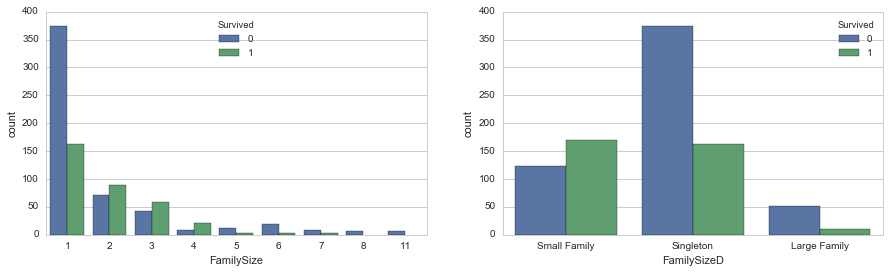

In [10]:
# FAMILY
# Create a family size variable = number parents/children + number siblings/spouses + 1 for the passenger themselves
titanic_df['FamilySize'] =  titanic_df["Parch"] + titanic_df["SibSp"] + 1
test_df['FamilySize'] =  test_df["Parch"] + test_df["SibSp"] + 1

fig, (axis1, axis2) = plt.subplots(1,2,figsize=(15,4))

# Plot the Family size showing number who survived and died
sns.countplot(x = 'FamilySize', hue= 'Survived', data = titanic_df, ax = axis1)

# Create function to be called on the FamilySize column that returns 'singleton', 'small' or 'large' depending on the size of the family
def discrete_family_size(x):
    if x == 1:
        return 'Singleton'
    elif x > 4:
        return 'Large Family'
    else:
        return 'Small Family'

# Apply the function to replace the values of FamilySize with the discretized values 
titanic_df['FamilySizeD'] = titanic_df['FamilySize'].apply(discrete_family_size)        
test_df['FamilySizeD'] = test_df['FamilySize'].apply(discrete_family_size) 
sns.countplot(x = 'FamilySizeD', hue= 'Survived', data = titanic_df, ax = axis2)    

In [11]:
# Create dummy variables for FamilySize
fsized_dummies_titanic = pd.get_dummies(titanic_df['FamilySizeD'])
fsized_dummies_test = pd.get_dummies(test_df['FamilySizeD'])

titanic_df = titanic_df.join(fsized_dummies_titanic)
test_df = test_df.join(fsized_dummies_test)

# Drop SibSp, ParCh, FamilySize as the information is contained in new dummy variables Singleton, Small and Large
titanic_df = titanic_df.drop(['SibSp','Parch', 'FamilySize', 'FamilySizeD'], axis=1)
test_df    = test_df.drop(['SibSp','Parch', 'FamilySize', 'FamilySizeD'], axis=1)

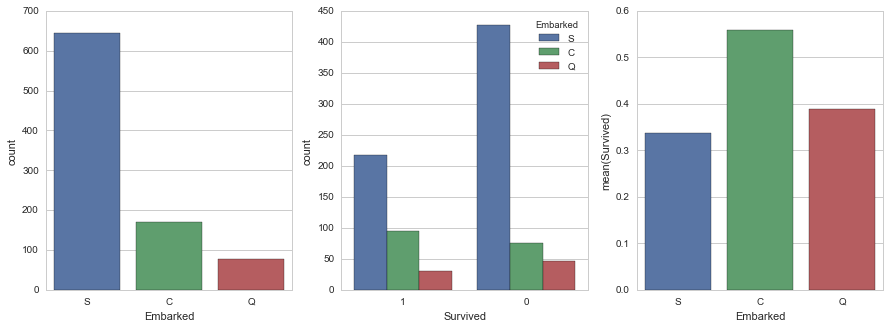

In [12]:
# MISSING VALUES

# EMBARKED
# Fill in the missing values for embarked using the value found as most likely by Megan Risdal's R script 
# where she looked at the fare paid by the people whose Embarked value is missing and looked at the others who paid this
# fare and found that Embarked for the group of people who paid this fare was Cherbourg
titanic_df["Embarked"] = titanic_df["Embarked"].fillna("C")

fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))
# create countplot showing embarked and another showing survived with different bars for where they embarked
sns.countplot(x='Embarked', data=titanic_df, ax=axis1)
sns.countplot(x='Survived', hue="Embarked", data=titanic_df, order=[1,0], ax=axis2)

# group by embarked, and get the mean for survived passengers for each value in Embarked
embark_perc = titanic_df[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=embark_perc,order=['S','C','Q'],ax=axis3)

In [13]:
# Create dummy variables for C, Q and S
embark_dummies_titanic = pd.get_dummies(titanic_df['Embarked'])
embark_dummies_test = pd.get_dummies(test_df['Embarked'])

titanic_df = titanic_df.join(embark_dummies_titanic)
test_df = test_df.join(embark_dummies_test)

# Dropped Embarked as C, Q and S have been added as dummy variables
titanic_df.drop(['Embarked'], axis=1,inplace=True)
test_df.drop(['Embarked'], axis=1,inplace=True)

In [14]:
# CABIN
# There are a huge amount of missing values. It wouldn't make sense to try to fill them in so I am dropping Cabin
titanic_df = titanic_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

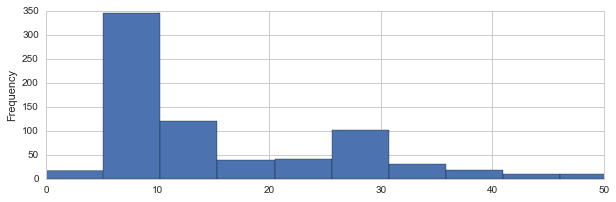

In [15]:
# FARE
# only for test_df, since there is a missing "Fare" values
# Filling in the missing value with the median Fare value
test_df["Fare"].fillna(test_df["Fare"].median(), inplace=True)

# convert from float to int 
titanic_df['Fare'] = titanic_df['Fare'].astype(int)
test_df['Fare']    = test_df['Fare'].astype(int)

# get fare for survived & didn't survive passengers 
fare_not_survived = titanic_df["Fare"][titanic_df["Survived"] == 0]
fare_survived     = titanic_df["Fare"][titanic_df["Survived"] == 1]

# get average and std for fare of survived/not survived passengers
avgerage_fare = DataFrame([fare_not_survived.mean(), fare_survived.mean()])
std_fare      = DataFrame([fare_not_survived.std(), fare_survived.std()])

# plot fare as a histogram
fig, axis1 = plt.subplots(1,1,figsize=(10,3))
fig = titanic_df['Fare'].plot(kind = 'hist', figsize=(10,3),bins=100, xlim=(0,50))

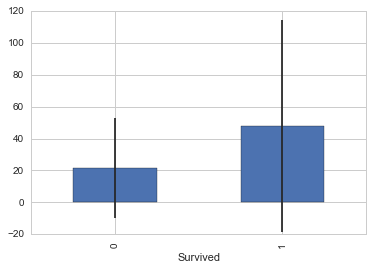

In [16]:
avgerage_fare.index.names = std_fare.index.names = ["Survived"]
avgerage_fare.plot(yerr=std_fare, kind = 'bar', legend = False)

C:\Users\barre\Miniconda2\envs\Siobhan\lib\site-packages\ipykernel\__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\barre\Miniconda2\envs\Siobhan\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


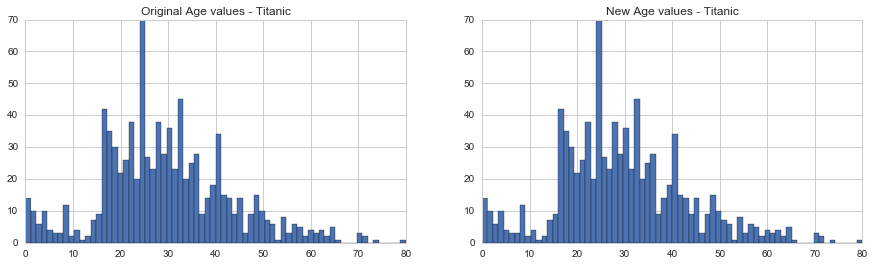

In [17]:
# AGE
# Create new figure with two axes
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
axis1.set_title('Original Age values - Titanic')
axis2.set_title('New Age values - Titanic')

# get average, std, and number of NaN values in titanic_df
average_age_titanic   = titanic_df["Age"].mean()
std_age_titanic       = titanic_df["Age"].std()
count_nan_age_titanic = titanic_df["Age"].isnull().sum() # take age column give me all those that are null and sum the amount(count the NANs)

# get average, std, and number of NaN values in test_df
average_age_test   = test_df["Age"].mean()
std_age_test       = test_df["Age"].std()
count_nan_age_test = test_df["Age"].isnull().sum()

rand_1 = np.random.randint(average_age_titanic - std_age_titanic, average_age_titanic + std_age_titanic, size = count_nan_age_titanic)
rand_2 = np.random.randint(average_age_test - std_age_test, average_age_test + std_age_test, size = count_nan_age_test)

# fill NaN values in Age column with random values generated
titanic_df["Age"][np.isnan(titanic_df["Age"])] = rand_1
test_df["Age"][np.isnan(test_df["Age"])] = rand_2

# convert from float to int
titanic_df['Age'] = titanic_df['Age'].astype(int)
test_df['Age']    = test_df['Age'].astype(int)

# plot original Age values
titanic_df['Age'].hist(bins=70, ax=axis1)

# plot new Age Values
titanic_df['Age'].hist(bins=70, ax=axis2)

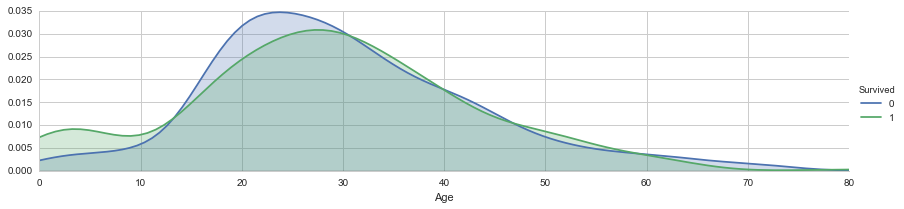

In [18]:
# Looking at average numbers of passengers who survived based on age
# peaks for survived/not survived passengers by their age
facet = sns.FacetGrid(titanic_df, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, titanic_df['Age'].max()))
facet.add_legend()

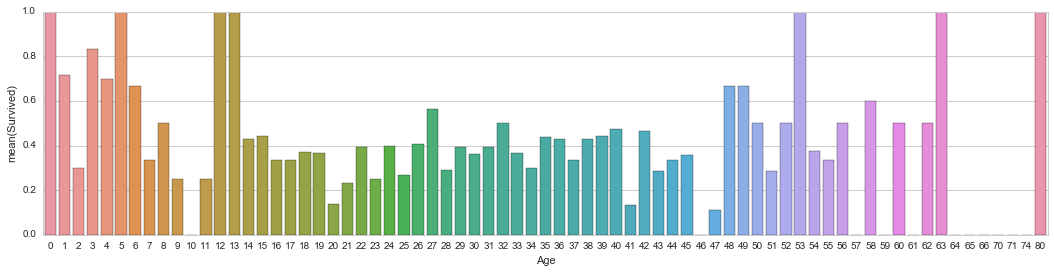

In [19]:
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_age = titanic_df[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()
sns.barplot(x='Age', y='Survived', data=average_age)
# There was a worse chance of surviving if you were between 14 and 47. Much better chance of surviving if you are over 48 or under 14 e.g.
# every child aged 0, 5, 12 and 13 survived. There may have been just one child aged 0 and they got on to a lifeboat first

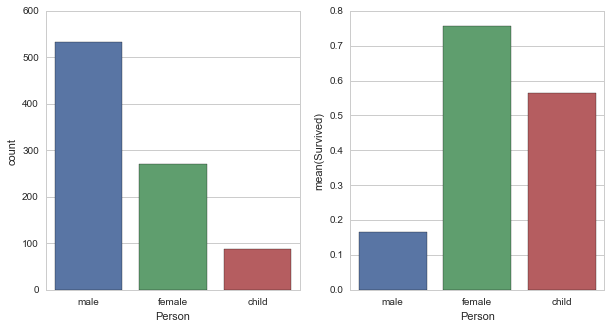

In [22]:
# SEX
# As we see, children(age < ~16) on aboard seem to have a high chances for Survival.
# So, we can classify passengers as males, females, and child
def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex

titanic_df['Person'] = titanic_df[['Age','Sex']].apply(get_person,axis=1)
test_df['Person'] = test_df[['Age','Sex']].apply(get_person,axis=1)

# No need to use Sex column since we created Person column
titanic_df.drop(['Sex'],axis=1,inplace=True)
test_df.drop(['Sex'],axis=1,inplace=True)

# create dummy variables for Person column
person_dummies_titanic  = pd.get_dummies(titanic_df['Person'])
person_dummies_titanic.columns = ['Child','Female','Male']
person_dummies_test  = pd.get_dummies(test_df['Person'])
person_dummies_test.columns = ['Child','Female','Male']

titanic_df = titanic_df.join(person_dummies_titanic)
test_df    = test_df.join(person_dummies_test)

fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5))
sns.countplot(x='Person', data=titanic_df, ax=axis1)

# average of survived for each Person(male, female, or child)
person_perc = titanic_df[["Person", "Survived"]].groupby(['Person'],as_index=False).mean()
sns.barplot(x='Person', y='Survived', data=person_perc, ax=axis2, order=['male','female','child'])


In [23]:
# Drop person column
titanic_df.drop(['Person'],axis=1,inplace=True)
test_df.drop(['Person'],axis=1,inplace=True)

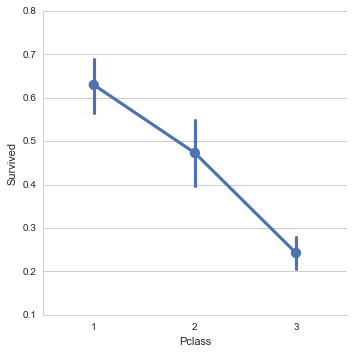

In [24]:
# PCLASS
# First class had a much higher level of survival
sns.factorplot('Pclass','Survived',order=[1,2,3], data=titanic_df,size=5)

In [25]:
#Print information about each
titanic_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 21 columns):
Survived          891 non-null int64
Pclass            891 non-null int64
Age               891 non-null int32
Fare              891 non-null int32
Dr                891 non-null float64
Master            891 non-null float64
Military Title    891 non-null float64
Miss              891 non-null float64
Mr                891 non-null float64
Mrs               891 non-null float64
Rare Title        891 non-null float64
Rev               891 non-null float64
Large Family      891 non-null float64
Singleton         891 non-null float64
Small Family      891 non-null float64
C                 891 non-null float64
Q                 891 non-null float64
S                 891 non-null float64
Child             891 non-null float64
Female            891 non-null float64
Male              891 non-null float64
dtypes: float64(17), int32(2), int64(2)
memory usage: 139.3 KB
<class 'pandas.core.f

In [26]:
# DEFINE TRAINING AND TESTING SETS
# X train and Y train are the same except for the removed survived column
X_train = titanic_df.drop("Survived", axis=1) # dropped the survived column
Y_train = titanic_df["Survived"] # the answer
X_test  = test_df.drop("PassengerId", axis=1).copy()


In [27]:
# MODELLING

# Logistic Regression
# Score is for the x_train performance against y train
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
lr_score = logreg.score(X_train, Y_train)
print 'Logistic Regression Score:', lr_score

Logistic Regression Score: 0.826038159371


In [28]:
# Logistic Regression using Cross Validation using logreg defined above
# accuracy is the prediction compared to Y_Train correct details.
LRPredict = cross_validation.cross_val_predict(logreg, X_train, Y_train, cv=10)
print 'Logistic Regression with cross validation accuracy: ', metrics.accuracy_score(Y_train, LRPredict) 


Logistic Regression with cross validation accuracy:  0.820426487093


In [29]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
rf_score = random_forest.score(X_train, Y_train)
print 'Random Forest score:', rf_score

# Random Forest with Cross Validationusing random_forest defined above
RFPredict = cross_validation.cross_val_predict(random_forest, X_train, Y_train, cv=10)
print 'Random Forest with cross validation accuracy: ', metrics.accuracy_score(Y_train, RFPredict) 

Random Forest score: 0.96632996633
Random Forest with cross validation accuracy:  0.799102132435


In [30]:
# K Nearest Neighbours
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
knn_score = knn.score(X_train, Y_train)
print 'KNN score:', knn_score

# K Nearest Neighbours with Cross Validation using knn defined above
KNNPredict = cross_validation.cross_val_predict(knn, X_train, Y_train, cv = 10)
print 'KNN with cross validation:', metrics.accuracy_score(Y_train, KNNPredict)

KNN score: 0.830527497194
KNN with cross validation: 0.704826038159


In [31]:
# Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
gnb_score = gaussian.score(X_train, Y_train)
print 'Gaussian Naive Bayes score:', gnb_score

# Gaussian Naive Bayes with cross validation
GNBPredict = cross_validation.cross_val_predict(gaussian, X_train, Y_train, cv = 10)
print 'Gaussian Naive Bayes with cross validation:', metrics.accuracy_score(Y_train, GNBPredict)

Gaussian Naive Bayes score: 0.783389450056
Gaussian Naive Bayes with cross validation: 0.775533108866


In [32]:
# Support Vector Machine using Cross Validation
cvSVC = SVC(kernel='linear', C=1)
SVCPredict = cross_validation.cross_val_predict(cvSVC, X_train, Y_train, cv=10)
print 'SVC with cross validation accuracy: ', metrics.accuracy_score(Y_train, SVCPredict) 

# Define function to get the prediction accuracy of Support Vector Machine
# This is my final model so I am defining it as a function so it can be tested
def get_prediction_accuracy(X_train, Y_train):
    svc = SVC()
    svc.fit(X_train, Y_train)
    return svc.score(X_train, Y_train)

print 'Support Vector Machine score:', get_prediction_accuracy(X_train, Y_train)

SVC with cross validation accuracy:  0.820426487093
Support Vector Machine score: 0.852974186308
